In [46]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

r = requests.get('http://ec2-54-175-179-28.compute-1.amazonaws.com/get_thinktron_data.php?device_id=5001&year_month=201909')
soup = BeautifulSoup(r.text,'lxml')
a = list(soup.find_all('p'))

In [47]:
# Split the list through the regular expression
d = re.split('\s+|,|<br/>',str(a))

# Remove the '' element from the list
d = list(filter(lambda zz: zz != '', d)) 

# Remove the '=' element from the list
d = list(filter(lambda zz: zz != '=', d))

In [48]:
# Create a dataframe
colName=['id', 'time', 'roll', 'pitch', 'yaw','field1','field2','field3']
_Num = 0
_df  = pd.DataFrame(columns=colName)
df   = pd.DataFrame(columns=colName)

for ii in range(0,len(d)):    
    while colName[_Num] in d[ii]:
        _lst = d[ii + 1]
        _lst = _lst.strip(',')
        
        if _lst == '' or (_lst in colName):
            _lst = None       
        
        _df[colName[_Num]] = [_lst] # Put the list into the dataframe
        if _Num < (len(colName)-1):
            _Num += 1
        else:
            df = df.append(_df, ignore_index=True)
            _Num = 0 

#df.to_csv('Result.csv')

In [49]:
# Convert argument to a numeric type(float64 or int64)
numericCol = ['roll', 'pitch', 'yaw','field1','field2','field3']
for ii in numericCol:
    df[ii] = pd.to_numeric(df[ii])

# Convert the format of date
import datetime
dates = df.time
df.index = pd.to_datetime(dates.astype(str), format='%Y%m%d%H%M%S')
df.index.name = 'time'
del df['time']

# Check dataframe format
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 652 entries, 2019-09-04 15:54:45 to 2019-09-24 16:45:03
Data columns (total 7 columns):
id        652 non-null object
roll      652 non-null float64
pitch     652 non-null float64
yaw       652 non-null int64
field1    652 non-null int64
field2    652 non-null int64
field3    652 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 40.8+ KB


In [55]:
# Set range of plotting data
startTime = "20190917130439"
startTime = pd.to_datetime(startTime, format='%Y%m%d%H%M%S')
dfPlot = df.loc[startTime:]

In [57]:
from datetime import datetime
from datetime import timedelta
threshold = timedelta(minutes = 15)

# Creat an empty dataframe 
_df = pd.DataFrame({"id":[5001],
                    "roll":[np.nan],
                    "pitch":[np.nan],
                    "yaw":[np.nan],
                    "field1":[np.nan],
                    "field2":[np.nan],
                    "field3":[np.nan]})
_df.index.name = 'time'

countNum = 0
startIndexNum = 0
while True:
    try:
        for ii in range(startIndexNum, len(dfPlot)):
            dt  = dfPlot.index[ii+1]-dfPlot.index[ii]        
            if (dt > threshold):
                # Put the row of NaN values into dataframe
                _dt = dfPlot.index[ii]-dfPlot.index[ii-1]
                _timestamp = dfPlot.index[ii] + _dt
                _df.index = [pd.to_datetime(_timestamp)] # Creat a list for containing a timestamp!!
                dfPlot = dfPlot.append(_df)
                dfPlot = dfPlot.sort_index()
                startIndexNum = ii + 1
                #print("countNum: ", countNum)
                #print("startIndexNum: ", startIndexNum)
                countNum += 1
                break
    except:
            print("Done!")
            break

Done!


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dfPlot)
    print(dfPlot.info())

D:\PythonProgm\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
D:\PythonProgm\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


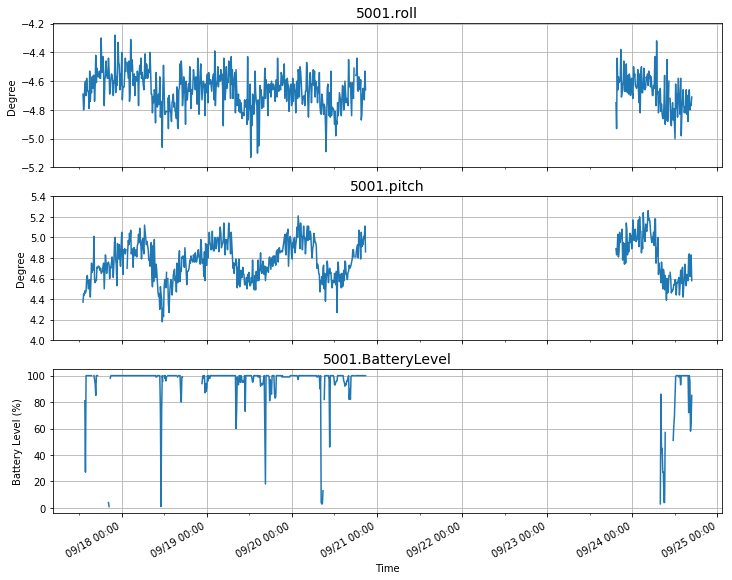

In [58]:
fig = plt.figure(num=1, figsize=[12,10])

plt.subplot(3, 1, 1)
# Share the x axis limits for one axis with another by passing an axes instance as a sharex
ax1 = plt.subplot(311)
ax1.set_title('5001.roll', fontdict = {'fontsize':14})
dfPlot.roll.plot()
plt.ylim(-5.2, -4.199)
plt.yticks(np.arange(-5.2, -4.199, step=0.2))
plt.ylabel('Degree')
minorLocator = MultipleLocator(0.5)
ax1.xaxis.set_minor_locator(minorLocator)
ax1.grid()

plt.subplot(3, 1, 2)
ax2 = plt.subplot(312, sharex=ax1)
ax2.set_title('5001.pitch', fontdict = {'fontsize':14})
dfPlot.pitch.plot()
plt.ylim(4, 5.4)
plt.yticks(np.arange(4, 5.4, step=0.2))
plt.ylabel('Degree')
minorLocator = MultipleLocator(0.5)
ax2.xaxis.set_minor_locator(minorLocator)
ax2.grid()

plt.subplot(3, 1, 3)
ax3 = plt.subplot(313, sharex=ax1)
ax3.set_title('5001.BatteryLevel', fontdict = {'fontsize':14})

dfPlot.field1[dfPlot.field1 == 0] = np.nan
dfPlot.field1.plot()
#plt.plot(plotDF2018.y)
#plt.ylim(0.2, 1.6)
#plt.yticks(np.arange(0.2, 1.61, step=0.2))

plt.xticks(rotation = 30)

ax3.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d %H:%M"))
#ax3.xaxis.set_minor_formatter(mdates.DateFormatter("%m/%d %H:%M"))
minorLocator = MultipleLocator(0.5)
ax3.xaxis.set_minor_locator(minorLocator)
ax3.grid()

plt.xlabel('Time')
plt.ylabel('Battery Level (%)')
plt.show()

fig.savefig('incline_ana_5001.jpg', dpi= 400)